# Clustering with 2023 data ONLY

Try with only 2023 data

In [ ]:
!pip install scipy==1.11.4

In [1]:
from calitp_data_analysis.sql import query_sql
from utils_transit_peer_groups import *
import sys
import altair as alt
import pandas as pd

sys.path.append("../ntd/monthly_ridership_report")
from update_vars import GCS_FILE_PATH, NTD_MODES, NTD_TOS

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [58]:
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
fixed_guideway = [
    "SR",
    "HR",
    "YR",
    "CR",
    "CC",
    "LR",
    "MG",
    "TB",
]

nonfixed_guideway = [
    "DR",
    "MB",
    "DT",
    "CB",
    "VP",
    "RB",
]

other_modes = [
    "FB",
    "OT", # no clue what this is, not in NTD glossary
    "OR", # same with this
    
]


In [40]:
ntd_2023_data.columns

Index(['ntd_id', 'source_agency', 'agency_status', 'city', 'primary_uza_name',
       'uza_population', 'uza_area_sq_miles', 'year', 'mode', 'service',
       'reporter_type', 'total_upt', 'total_voms', 'total_vrh', 'total_vrm',
       'opexp_total'],
      dtype='object')

In [41]:
#ID cols
id_cols = [
    "ntd_id",
    "source_agency",
    "city",
    "primary_uza_name"
]
# include in clustering
categorical_cols = ["mode", "service", "reporter_type"]

# include in clustering
numerical_cols = [
    "total_upt",
    "total_vrh",
    "total_vrm",
    "opexp_total",
    "total_voms",
    # "uza_population",
    # "uza_area_sq_miles",
]

In [5]:
# alt method to query warehous data, via cal-itp docs
query = f"""
        SELECT
          upt.ntd_id,
          upt.source_agency,
          upt.agency_status,
          upt.city,
          upt.primary_uza_name,
          upt.uza_population,
          upt.uza_area_sq_miles,
          upt.year,
          upt.mode,
          upt.service,
          upt.reporter_type,
          SUM(upt.upt) AS total_upt,
          SUM(voms.voms) AS total_voms,
          SUM(vrh.vrh) AS total_vrh,
          SUM(vrm.vrm) AS total_vrm,
          SUM(opexp_total.opexp_total) AS opexp_total
        FROM
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_upt AS upt
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_voms AS voms
        ON
          upt.ntd_id = voms.ntd_id
          AND upt.year = voms.year
          AND upt.source_agency = voms.source_agency
          AND upt.agency_status = voms.agency_status
          AND upt.primary_uza_name = voms.primary_uza_name
          AND upt.uza_population = voms.uza_population
          AND upt.uza_area_sq_miles = voms.uza_area_sq_miles
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrh AS vrh
        ON
          upt.ntd_id = vrh.ntd_id
          AND upt.year = vrh.year
          AND upt.source_agency = vrh.source_agency
          AND upt.agency_status = vrh.agency_status
          AND upt.primary_uza_name = vrh.primary_uza_name
          AND upt.uza_population = vrh.uza_population
          AND upt.uza_area_sq_miles = vrh.uza_area_sq_miles
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrm AS vrm
        ON
          upt.ntd_id = vrm.ntd_id
          AND upt.year = vrm.year
          AND upt.source_agency = vrm.source_agency
          AND upt.agency_status = vrm.agency_status
          AND upt.primary_uza_name = vrm.primary_uza_name
          AND upt.uza_population = vrm.uza_population
          AND upt.uza_area_sq_miles = vrm.uza_area_sq_miles
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_opexp_total AS opexp_total
        ON
          upt.ntd_id = opexp_total.ntd_id
          AND upt.year = opexp_total.year
          AND upt.source_agency = opexp_total.source_agency
          AND upt.agency_status = opexp_total.agency_status
          AND upt.primary_uza_name = opexp_total.primary_uza_name
          AND upt.uza_population = opexp_total.uza_population
          AND upt.uza_area_sq_miles = opexp_total.uza_area_sq_miles
        WHERE
          upt.source_state = "CA"
          AND upt.year = 2023
        GROUP BY
          upt.ntd_id,
          upt.source_agency,
          upt.agency_status,
          upt.city,
          upt.year,
          upt.primary_uza_name,
          upt.uza_population,
          upt.uza_area_sq_miles,
          upt.mode,
          upt.service,
          upt.reporter_type
        """

ntd_2023_data = query_sql(query).fillna(0)

In [6]:
ntd_2023_data[numerical_cols] = ntd_2023_data[numerical_cols].astype("int64", errors="ignore")

In [7]:
service_dict = {
    "TX":"PT",
    "TN":"PT"
}

ntd_2023_data["service"] = ntd_2023_data["service"].replace(service_dict)

In [8]:
ntd_2023_data["service"].unique()

array(['PT', 'DO'], dtype=object)

## 2023 - explore data

In [9]:
display(
    ntd_2023_data.info(),

    ntd_2023_data.head(),

    ntd_2023_data["service"].value_counts(),

    ntd_2023_data["mode"].value_counts(),
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ntd_id             667 non-null    object 
 1   source_agency      667 non-null    object 
 2   agency_status      667 non-null    object 
 3   city               667 non-null    object 
 4   primary_uza_name   667 non-null    object 
 5   uza_population     667 non-null    int64  
 6   uza_area_sq_miles  667 non-null    float64
 7   year               667 non-null    int64  
 8   mode               667 non-null    object 
 9   service            667 non-null    object 
 10  reporter_type      667 non-null    object 
 11  total_upt          667 non-null    int64  
 12  total_voms         667 non-null    int64  
 13  total_vrh          667 non-null    int64  
 14  total_vrm          667 non-null    int64  
 15  opexp_total        667 non-null    int64  
dtypes: float64(1), int64(7), o

None

,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total
0,90198,City of Porterville (COLT) - Transit Department,Active,Porterville,"Porterville, CA",69862,16.35,2023,MB,PT,Building Reporter,0,0,0,0,0
1,90198,City of Porterville (COLT) - Transit Department,Active,Porterville,"Porterville, CA",69862,16.35,2023,DR,PT,Building Reporter,0,0,0,0,0
2,90036,Orange County Transportation Authority (OCTA),Active,Orange,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,SR,PT,Full Reporter,0,1075448,2764357893,37310649233,428923289696
3,90036,Orange County Transportation Authority (OCTA),Active,Orange,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DT,PT,Full Reporter,0,1075448,2764357893,37310649233,428923289696
4,90036,Orange County Transportation Authority (OCTA),Active,Orange,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,CB,DO,Full Reporter,0,1075448,2764357893,37310649233,428923289696


PT    437
DO    230
Name: service, dtype: int64

DR    263
MB    244
CB     51
DT     39
VP     21
CR      8
LR      8
OT      7
FB      7
RB      4
HR      3
YR      3
SR      2
OR      2
MG      2
TB      1
CC      1
JT      1
Name: mode, dtype: int64

## 2023 - correlation matrix

In [10]:
ntd_2023_data[numerical_cols].corr()

,total_upt,total_vrh,total_vrm,opexp_total,total_voms
total_upt,1.000000,0.447327,0.438990,0.467137,0.428977
total_vrh,0.447327,1.000000,0.993603,0.970093,0.992880
total_vrm,0.438990,0.993603,1.000000,0.958037,0.991704
opexp_total,0.467137,0.970093,0.958037,1.000000,0.939107
total_voms,0.428977,0.992880,0.991704,0.939107,1.000000


## 2023 - Manual Hierarchal clustering w/ ward

In [11]:
from sklearn.cluster import AgglomerativeClustering 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [12]:
# 1. set up pre-processing steps with column transformer

preprocessor = ColumnTransformer(
    [
        ("ntd_metrics", StandardScaler(), numerical_cols),
        ("categorical", OneHotEncoder(drop="first", sparse_output=False), categorical_cols)
    ]
)
preprocessor

,transformers,"[('ntd_metrics', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [13]:
# 2. set up pipeline. First pre-processing, then clustering
pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("clustering", AgglomerativeClustering(n_clusters=10, linkage="ward"))
    ]
)

pipeline

,steps,"[('preprocessing', ...), ('clustering', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ntd_metrics', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
# 3. use pipeline to fit clustering model. create new column for clustering
ntd_2023_fit = ntd_2023_data.copy() # why do i need to copy/clone?

ntd_2023_fit["cluster_name"] = pipeline.fit_predict(ntd_2023_fit)

In [15]:
display(
    ntd_2023_fit["cluster_name"].value_counts(),
    ntd_2023_fit[["source_agency","total_upt","total_vrh","cluster_name"]].sample(3)
)

0    167
2    135
3    114
1    103
4     84
6     45
7     10
9      7
8      1
5      1
Name: cluster_name, dtype: int64

,source_agency,total_upt,total_vrh,cluster_name
532,City of Moorpark (MCT) - Public Works,0,46432,4
176,City of Santa Monica (BBB) - Department of Tra...,14431250,52118000,3
291,MTS Contract Services (MCS),0,0,3


In [16]:
ntd_2023_data["service"].unique()

array(['PT', 'DO'], dtype=object)

### what are the feature columns with onehotencoding drop=first?

In [17]:
feature_names = preprocessor.get_feature_names_out()
display(list(feature_names))

['ntd_metrics__total_upt',
 'ntd_metrics__total_vrh',
 'ntd_metrics__total_vrm',
 'ntd_metrics__opexp_total',
 'ntd_metrics__total_voms',
 'categorical__mode_CC',
 'categorical__mode_CR',
 'categorical__mode_DR',
 'categorical__mode_DT',
 'categorical__mode_FB',
 'categorical__mode_HR',
 'categorical__mode_JT',
 'categorical__mode_LR',
 'categorical__mode_MB',
 'categorical__mode_MG',
 'categorical__mode_OR',
 'categorical__mode_OT',
 'categorical__mode_RB',
 'categorical__mode_SR',
 'categorical__mode_TB',
 'categorical__mode_VP',
 'categorical__mode_YR',
 'categorical__service_PT',
 'categorical__reporter_type_Full Reporter',
 'categorical__reporter_type_Reduced Reporter',
 'categorical__reporter_type_Rural Reporter',
 'categorical__reporter_type_Separate Service']

### what are the feature columns with `onehotencoding drop=None`?


In [18]:
preprocessor_2 = ColumnTransformer(
    [
        ("ntd_metrics", StandardScaler(), numerical_cols),
        ("categorical", OneHotEncoder(
            # drop="first", 
            sparse_output=False
        ), categorical_cols)
    ]
)

pipeline_2 = Pipeline(
    [
        ("preprocessing", preprocessor_2),
        ("clustering", AgglomerativeClustering(n_clusters=10, linkage="ward"))
    ]
)

ntd_2023_fit_2 = ntd_2023_data.copy()

ntd_2023_fit_2["cluster"] = pipeline_2.fit_predict(ntd_2023_fit_2)

In [19]:
feature_names_2= preprocessor_2.get_feature_names_out()

display(list(feature_names_2)) # service_DO appears

['ntd_metrics__total_upt',
 'ntd_metrics__total_vrh',
 'ntd_metrics__total_vrm',
 'ntd_metrics__opexp_total',
 'ntd_metrics__total_voms',
 'categorical__mode_CB',
 'categorical__mode_CC',
 'categorical__mode_CR',
 'categorical__mode_DR',
 'categorical__mode_DT',
 'categorical__mode_FB',
 'categorical__mode_HR',
 'categorical__mode_JT',
 'categorical__mode_LR',
 'categorical__mode_MB',
 'categorical__mode_MG',
 'categorical__mode_OR',
 'categorical__mode_OT',
 'categorical__mode_RB',
 'categorical__mode_SR',
 'categorical__mode_TB',
 'categorical__mode_VP',
 'categorical__mode_YR',
 'categorical__service_DO',
 'categorical__service_PT',
 'categorical__reporter_type_Building Reporter',
 'categorical__reporter_type_Full Reporter',
 'categorical__reporter_type_Reduced Reporter',
 'categorical__reporter_type_Rural Reporter',
 'categorical__reporter_type_Separate Service']

## Using utils function to cluster

### 2023 data, all modes, PT/DO service

In [104]:
cluster_2023 = make_hierarchal_clustering(
    data = ntd_2023_data,
    num_cols = numerical_cols,
    cat_cols = categorical_cols,
    cluster_num = 10
    
)

for i in cluster_2023["cluster_name"].unique():
    print(f"""
    \n How many unique agencies are in Cluster {i}: {cluster_2023[cluster_2023['cluster_name']==i]["source_agency"].nunique()}
    Cluster {i} sample:""")
    display(cluster_2023[cluster_2023["cluster_name"]==i].head()),
    print(f"\nCluster {i} summary stats:")
    display(cluster_2023[cluster_2023["cluster_name"]==i].describe())



    
 How many unique agencies are in Cluster 2: 52
    Cluster 2 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
0,90198,City of Porterville (COLT) - Transit Department,Active,Porterville,"Porterville, CA",69862,16.35,2023,MB,PT,Building Reporter,0,0,0,0,0,2
1,90198,City of Porterville (COLT) - Transit Department,Active,Porterville,"Porterville, CA",69862,16.35,2023,DR,PT,Building Reporter,0,0,0,0,0,2
37,91063,Calaveras County Department of Public Works,Inactive,0,California Non-UZA,4357850,0.00,2023,MB,PT,Rural Reporter,0,0,0,0,0,2
49,91018,City of Arcata (A&MRTS),Active,Arcata,California Non-UZA,4357850,0.00,2023,MB,DO,Rural Reporter,0,16,45384,609936,8749840,2
50,91018,City of Arcata (A&MRTS),Active,Arcata,California Non-UZA,4357850,0.00,2023,MB,PT,Rural Reporter,1010240,16,45384,609936,8749840,2



Cluster 2 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.350000e+02,135.000000,135.0,1.350000e+02,135.000000,1.350000e+02,1.350000e+02,1.350000e+02,135.0
mean,4.191493e+06,14.593185,2023.0,5.063414e+06,544.118519,8.309310e+05,1.501282e+07,8.795276e+07,2.0
std,7.443722e+05,79.682494,0.0,2.253151e+07,985.680855,1.301302e+06,2.543555e+07,1.263981e+08,0.0
min,6.986200e+04,0.000000,2023.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.0
25%,4.357850e+06,0.000000,2023.0,0.000000e+00,16.000000,2.755200e+04,4.469760e+05,3.327381e+06,2.0
50%,4.357850e+06,0.000000,2023.0,3.537700e+04,162.000000,2.943920e+05,5.318224e+06,3.177709e+07,2.0
75%,4.357850e+06,0.000000,2023.0,1.021171e+06,493.000000,7.642080e+05,1.615850e+07,1.248204e+08,2.0
max,4.357850e+06,467.580000,2023.0,2.164316e+08,4160.000000,4.746250e+06,1.059334e+08,4.552014e+08,2.0



    
 How many unique agencies are in Cluster 7: 1
    Cluster 7 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
2,90036,Orange County Transportation Authority (OCTA),Active,Orange,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,SR,PT,Full Reporter,0,1075448,2764357893,37310649233,428923289696,7
3,90036,Orange County Transportation Authority (OCTA),Active,Orange,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DT,PT,Full Reporter,0,1075448,2764357893,37310649233,428923289696,7
4,90036,Orange County Transportation Authority (OCTA),Active,Orange,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,CB,DO,Full Reporter,0,1075448,2764357893,37310649233,428923289696,7
5,90036,Orange County Transportation Authority (OCTA),Active,Orange,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,VP,DO,Full Reporter,0,1075448,2764357893,37310649233,428923289696,7
6,90036,Orange County Transportation Authority (OCTA),Active,Orange,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,CB,PT,Full Reporter,0,1075448,2764357893,37310649233,428923289696,7



Cluster 7 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,10.0,10.00,10.0,1.000000e+01,10.0,1.000000e+01,1.000000e+01,1.000000e+01,10.0
mean,12237376.0,1636.83,2023.0,1.469522e+10,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,7.0
std,0.0,0.00,0.0,3.987980e+10,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
min,12237376.0,1636.83,2023.0,0.000000e+00,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,7.0
25%,12237376.0,1636.83,2023.0,0.000000e+00,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,7.0
50%,12237376.0,1636.83,2023.0,0.000000e+00,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,7.0
75%,12237376.0,1636.83,2023.0,4.257365e+09,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,7.0
max,12237376.0,1636.83,2023.0,1.277545e+11,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,7.0



    
 How many unique agencies are in Cluster 8: 1
    Cluster 8 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
12,90036,Orange County Transportation Authority (OCTA),Active,Orange,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,MB,DO,Full Reporter,331437877573,1075448,2764357893,37310649233,428923289696,8



Cluster 8 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.0,1.00,1.0,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0
mean,12237376.0,1636.83,2023.0,3.314379e+11,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,8.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,12237376.0,1636.83,2023.0,3.314379e+11,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,8.0
25%,12237376.0,1636.83,2023.0,3.314379e+11,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,8.0
50%,12237376.0,1636.83,2023.0,3.314379e+11,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,8.0
75%,12237376.0,1636.83,2023.0,3.314379e+11,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,8.0
max,12237376.0,1636.83,2023.0,3.314379e+11,1075448.0,2.764358e+09,3.731065e+10,4.289233e+11,8.0



    
 How many unique agencies are in Cluster 6: 10
    Cluster 6 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
13,90013,Santa Clara Valley Transportation Authority (VTA),Active,San Jose,"San Jose, CA",1837446,285.48,2023,HR,DO,Full Reporter,0,262144,887382528,11150999040,232484337152,6
14,90013,Santa Clara Valley Transportation Authority (VTA),Active,San Jose,"San Jose, CA",1837446,285.48,2023,DT,PT,Full Reporter,0,262144,887382528,11150999040,232484337152,6
15,90013,Santa Clara Valley Transportation Authority (VTA),Active,San Jose,"San Jose, CA",1837446,285.48,2023,VP,PT,Full Reporter,0,262144,887382528,11150999040,232484337152,6
16,90013,Santa Clara Valley Transportation Authority (VTA),Active,San Jose,"San Jose, CA",1837446,285.48,2023,DR,PT,Full Reporter,0,262144,887382528,11150999040,232484337152,6
17,90013,Santa Clara Valley Transportation Authority (VTA),Active,San Jose,"San Jose, CA",1837446,285.48,2023,LR,DO,Full Reporter,16989417472,262144,887382528,11150999040,232484337152,6



Cluster 6 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,4.500000e+01,45.000000,45.0,4.500000e+01,45.000000,4.500000e+01,4.500000e+01,4.500000e+01,45.0
mean,2.747331e+06,497.341778,2023.0,1.764220e+10,185707.844444,6.417495e+08,7.965985e+09,1.552494e+11,6.0
std,8.992692e+05,173.349228,0.0,3.333699e+10,80452.274970,3.353118e+08,3.256201e+09,9.708539e+10,0.0
min,4.148470e+05,92.460000,2023.0,0.000000e+00,71496.000000,1.407972e+08,1.683439e+09,3.127434e+10,6.0
25%,1.946618e+06,467.580000,2023.0,0.000000e+00,128282.000000,3.496597e+08,4.827739e+09,9.782312e+10,6.0
50%,3.070300e+06,513.800000,2023.0,7.898212e+08,137781.000000,4.422993e+08,8.302616e+09,1.149998e+11,6.0
75%,3.515933e+06,674.720000,2023.0,1.852398e+10,265482.000000,8.873825e+08,1.115100e+10,2.324843e+11,6.0
max,3.515933e+06,674.720000,2023.0,1.725164e+11,265482.000000,1.132665e+09,1.169491e+10,3.342516e+11,6.0



    
 How many unique agencies are in Cluster 3: 82
    Cluster 3 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
21,90170,ATC / Vancom,Inactive,0,"San Francisco--Oakland, CA",3515933,513.80,2023,DR,PT,Full Reporter,0,0,0,0,0,3
23,90157,Access Services (AS),Active,El Monte,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DR,PT,Full Reporter,212227047,24840,52087617,863173746,5569456833,3
24,90157,Access Services (AS),Active,El Monte,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DR,PT,Full Reporter,74948247,24840,52087617,863173746,5569456833,3
25,90014,Alameda-Contra Costa Transit District,Active,Oakland,"San Francisco--Oakland, CA",3515933,513.80,2023,DR,DO,Full Reporter,0,133920,442299312,4827739104,114999842880,3
28,90014,Alameda-Contra Costa Transit District,Active,Oakland,"San Francisco--Oakland, CA",3515933,513.80,2023,DR,PT,Full Reporter,543397248,133920,442299312,4827739104,114999842880,3



Cluster 3 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.140000e+02,114.000000,114.0,1.140000e+02,114.000000,1.140000e+02,1.140000e+02,1.140000e+02,114.0
mean,4.204821e+06,622.805263,2023.0,5.683640e+07,19976.614035,5.144135e+07,7.408229e+08,1.145009e+10,3.0
std,5.046791e+06,652.689357,0.0,1.804948e+08,36153.745020,1.022692e+08,1.597629e+09,2.526337e+10,0.0
min,5.690400e+04,14.110000,2023.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.0
25%,2.828555e+05,70.380000,2023.0,0.000000e+00,196.000000,4.526400e+05,6.841968e+06,6.014878e+07,3.0
50%,1.946618e+06,467.580000,2023.0,6.345440e+05,2052.000000,5.539889e+06,7.066557e+07,7.003947e+08,3.0
75%,1.223738e+07,1636.830000,2023.0,1.280122e+07,20088.000000,5.208762e+07,6.168509e+08,7.956058e+09,3.0
max,1.223738e+07,1636.830000,2023.0,1.212473e+09,137781.000000,4.422993e+08,1.065422e+10,1.149998e+11,3.0



    
 How many unique agencies are in Cluster 0: 92
    Cluster 0 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
22,90157,Access Services (AS),Active,El Monte,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DT,PT,Full Reporter,0,24840,52087617,863173746,5569456833,0
31,90182,Altamont Corridor Express (ACE),Active,Stockton,"Stockton, CA",414847,92.46,2023,MB,PT,Full Reporter,0,216,198656,7908240,289204088,0
32,90182,Altamont Corridor Express (ACE),Active,Stockton,"Stockton, CA",414847,92.46,2023,CR,PT,Full Reporter,7591968,216,198656,7908240,289204088,0
33,90121,Antelope Valley Transit Authority (AVTA),Active,Lancaster,"Palmdale--Lancaster, CA",359559,84.78,2023,DT,PT,Full Reporter,0,5504,14106304,225935616,2014672512,0
35,90121,Antelope Valley Transit Authority (AVTA),Active,Lancaster,"Palmdale--Lancaster, CA",359559,84.78,2023,MB,PT,Full Reporter,283383808,5504,14106304,225935616,2014672512,0



Cluster 0 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.670000e+02,167.000000,167.0,1.670000e+02,167.000000,1.670000e+02,1.670000e+02,1.670000e+02,167.0
mean,3.795923e+06,566.690599,2023.0,3.424219e+08,12699.658683,2.969161e+07,4.180824e+08,5.791185e+09,0.0
std,4.949665e+06,644.912562,0.0,1.312780e+09,23974.500684,5.951534e+07,8.418018e+08,1.305729e+10,0.0
min,5.690400e+04,12.160000,2023.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,2.021970e+05,60.450000,2023.0,0.000000e+00,212.000000,3.025010e+05,7.818472e+06,8.431397e+07,0.0
50%,5.385830e+05,159.110000,2023.0,9.097390e+05,1728.000000,4.338560e+06,7.580652e+07,6.575637e+08,0.0
75%,3.515933e+06,674.720000,2023.0,4.576370e+07,17728.000000,3.047212e+07,4.923401e+08,6.612736e+09,0.0
max,1.223738e+07,1636.830000,2023.0,1.048781e+10,137781.000000,3.833709e+08,5.980799e+09,9.893141e+10,0.0



    
 How many unique agencies are in Cluster 1: 76
    Cluster 1 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
51,90300,City of Artesia - Transportation Division,Active,Artesia,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DT,PT,Reduced Reporter,0,40,2296,37696,219984,1
53,90194,City of Atascadero - Public Works,Active,Atascadero,"El Paso de Robles (Paso Robles)--Atascadero, CA",67804,29.96,2023,MB,PT,Reduced Reporter,0,16,23496,272896,3774760,1
55,90249,City of Avalon,Active,Avalon,California Non-UZA,4357850,0.00,2023,DT,PT,Reduced Reporter,0,108,253935,1122093,25475229,1
57,90249,City of Avalon,Active,Avalon,California Non-UZA,4357850,0.00,2023,MB,PT,Reduced Reporter,1360071,108,253935,1122093,25475229,1
58,90252,City of Bell - Community Services Department,Active,Bell,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DT,PT,Reduced Reporter,0,640,346560,3175552,23752576,1



Cluster 1 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.030000e+02,103.000000,103.0,1.030000e+02,103.000000,1.030000e+02,1.030000e+02,1.030000e+02,103.0
mean,6.713467e+06,857.399709,2023.0,4.184838e+06,339.485437,4.856105e+05,6.411220e+06,6.390660e+07,1.0
std,5.531426e+06,771.077584,0.0,1.692059e+07,502.349653,7.190571e+05,1.018929e+07,9.545290e+07,0.0
min,5.428700e+04,0.000000,2023.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0
25%,4.731760e+05,30.000000,2023.0,0.000000e+00,16.000000,1.814250e+04,2.539040e+05,2.719626e+06,1.0
50%,4.357850e+06,513.800000,2023.0,3.303840e+05,120.000000,2.081600e+05,2.011408e+06,2.086890e+07,1.0
75%,1.223738e+07,1636.830000,2023.0,2.510040e+06,445.500000,5.252850e+05,6.618395e+06,7.000592e+07,1.0
max,1.223738e+07,1636.830000,2023.0,1.587587e+08,2375.000000,2.868096e+06,5.222421e+07,3.561569e+08,1.0



    
 How many unique agencies are in Cluster 4: 77
    Cluster 4 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
52,90300,City of Artesia - Transportation Division,Active,Artesia,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DR,PT,Reduced Reporter,31936,40,2296,37696,219984,4
54,90194,City of Atascadero - Public Works,Active,Atascadero,"El Paso de Robles (Paso Robles)--Atascadero, CA",67804,29.96,2023,DR,PT,Reduced Reporter,118448,16,23496,272896,3774760,4
56,90249,City of Avalon,Active,Avalon,California Non-UZA,4357850,0.00,2023,DR,PT,Reduced Reporter,623457,108,253935,1122093,25475229,4
59,90252,City of Bell - Community Services Department,Active,Bell,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DR,PT,Reduced Reporter,1090560,640,346560,3175552,23752576,4
61,90252,City of Bell - Community Services Department,Active,Bell,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DR,PT,Reduced Reporter,287488,640,346560,3175552,23752576,4



Cluster 4 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,8.400000e+01,84.000000,84.0,8.400000e+01,84.000000,8.400000e+01,8.400000e+01,8.400000e+01,84.0
mean,7.150233e+06,931.148214,2023.0,8.952933e+05,269.035714,3.489746e+05,4.624385e+06,4.597129e+07,4.0
std,5.610142e+06,771.578926,0.0,2.226828e+06,445.827981,5.789576e+05,8.444561e+06,7.716639e+07,0.0
min,5.428700e+04,0.000000,2023.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.0
25%,3.573010e+05,63.997500,2023.0,8.167250e+03,15.000000,1.010000e+04,1.019830e+05,1.357584e+06,4.0
50%,1.223738e+07,1636.830000,2023.0,1.294080e+05,100.000000,1.279320e+05,1.160568e+06,1.552865e+07,4.0
75%,1.223738e+07,1636.830000,2023.0,6.954600e+05,405.000000,4.098060e+05,3.982808e+06,5.518748e+07,4.0
max,1.223738e+07,1636.830000,2023.0,1.376500e+07,2375.000000,2.868096e+06,5.222421e+07,3.561569e+08,4.0



    
 How many unique agencies are in Cluster 9: 1
    Cluster 9 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
280,90154,Los Angeles County Metropolitan Transportation...,Active,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,DR,PT,Full Reporter,0,1357312,4208721920,56047345152,1124671686144,9
281,90154,Los Angeles County Metropolitan Transportation...,Active,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,LR,DO,Full Reporter,149864353792,1357312,4208721920,56047345152,1124671686144,9
282,90154,Los Angeles County Metropolitan Transportation...,Active,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,MB,PT,Full Reporter,39213907968,1357312,4208721920,56047345152,1124671686144,9
284,90154,Los Angeles County Metropolitan Transportation...,Active,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,HR,DO,Full Reporter,109997854720,1357312,4208721920,56047345152,1124671686144,9
285,90154,Los Angeles County Metropolitan Transportation...,Active,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,RB,DO,Full Reporter,17907421184,1357312,4208721920,56047345152,1124671686144,9



Cluster 9 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,7.0,7.00,7.0,7.000000e+00,7.0,7.000000e+00,7.000000e+00,7.000000e+00,7.0
mean,12237376.0,1636.83,2023.0,4.659827e+10,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,9.0
std,0.0,0.00,0.0,5.953424e+10,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
min,12237376.0,1636.83,2023.0,0.000000e+00,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,9.0
25%,12237376.0,1636.83,2023.0,4.602190e+09,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,9.0
50%,12237376.0,1636.83,2023.0,1.790742e+10,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,9.0
75%,12237376.0,1636.83,2023.0,7.460588e+10,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,9.0
max,12237376.0,1636.83,2023.0,1.498644e+11,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,9.0



    
 How many unique agencies are in Cluster 5: 1
    Cluster 5 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
283,90154,Los Angeles County Metropolitan Transportation...,Active,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,MB,DO,Full Reporter,805546905600,1357312,4208721920,56047345152,1124671686144,5



Cluster 5 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.0,1.00,1.0,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0
mean,12237376.0,1636.83,2023.0,8.055469e+11,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,5.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,12237376.0,1636.83,2023.0,8.055469e+11,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,5.0
25%,12237376.0,1636.83,2023.0,8.055469e+11,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,5.0
50%,12237376.0,1636.83,2023.0,8.055469e+11,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,5.0
75%,12237376.0,1636.83,2023.0,8.055469e+11,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,5.0
max,12237376.0,1636.83,2023.0,8.055469e+11,1357312.0,4.208722e+09,5.604735e+10,1.124672e+12,5.0


### 2023 data, non-fixed route modes , PT/DO service

In [70]:
non_fixed_route_data = ntd_2023_data[
    ntd_2023_data["mode"].isin(nonfixed_guideway)
].groupby(id_cols+categorical_cols).agg({
    i:"sum" for i in numerical_cols
}).reset_index()

non_fixed_route_data.head()


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms
0,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",DR,PT,Full Reporter,0,340509250,10654218625,97823119750,72750
1,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",MB,PT,Full Reporter,0,340509250,10654218625,97823119750,72750
2,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",DR,DO,Full Reporter,13196115,7812126,105948432,986968422,2403
3,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",DR,PT,Full Reporter,0,7812126,105948432,986968422,2403
4,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",MB,DO,Full Reporter,253584918,7812126,105948432,986968422,2403



    
 How many unique agencies are in Cluster 1: 89
    Cluster 1 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
0,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",DR,PT,Full Reporter,0,340509250,10654218625,97823119750,72750,1
1,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",MB,PT,Full Reporter,0,340509250,10654218625,97823119750,72750,1
2,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",DR,DO,Full Reporter,13196115,7812126,105948432,986968422,2403,1
3,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",DR,PT,Full Reporter,0,7812126,105948432,986968422,2403,1
5,90006,Santa Cruz Metropolitan Transit District (SCMTD),Santa Cruz,"Santa Cruz, CA",CB,DO,Full Reporter,174624336,46385568,642627216,10490973336,20088,1



Cluster 1 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.720000e+02,1.720000e+02,1.720000e+02,1.720000e+02,172.000000,172.0
mean,8.277534e+08,7.146593e+07,1.029122e+09,1.588309e+10,27477.220930,1.0
std,4.403331e+09,1.233105e+08,1.884944e+09,3.047603e+10,43754.353623,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.0
25%,0.000000e+00,8.515335e+05,1.259860e+07,1.398834e+08,505.500000,1.0
50%,2.914135e+05,7.812126e+06,1.531007e+08,1.066427e+09,3888.000000,1.0
75%,1.515672e+07,5.990221e+07,9.834629e+08,1.049097e+10,29155.000000,1.0
max,3.891870e+10,4.422993e+08,1.065422e+10,1.149998e+11,186000.000000,1.0



    
 How many unique agencies are in Cluster 7: 77
    Cluster 7 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
4,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",MB,DO,Full Reporter,253584918,7812126,105948432,986968422,2403,7
9,90006,Santa Cruz Metropolitan Transit District (SCMTD),Santa Cruz,"Santa Cruz, CA",MB,DO,Full Reporter,4070815056,46385568,642627216,10490973336,20088,7
10,90006,Santa Cruz Metropolitan Transit District (SCMTD),Santa Cruz,"Santa Cruz, CA",MB,PT,Full Reporter,0,46385568,642627216,10490973336,20088,7
13,90007,City of Modesto (MAX),0,"Modesto, CA",MB,DO,Full Reporter,0,0,0,0,0,7
14,90007,City of Modesto (MAX),0,"Modesto, CA",MB,PT,Full Reporter,0,0,0,0,0,7



Cluster 7 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01,94.000000,94.0
mean,5.894703e+08,1.880616e+07,2.575125e+08,3.568113e+09,8145.978723,7.0
std,1.711870e+09,3.749544e+07,5.070189e+08,7.459449e+09,16138.648603,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,7.0
25%,0.000000e+00,2.707240e+05,3.690576e+06,4.647613e+07,100.000000,7.0
50%,9.443168e+06,2.703632e+06,4.531610e+07,4.491905e+08,1201.500000,7.0
75%,1.935468e+08,1.714062e+07,2.660757e+08,3.122231e+09,7474.250000,7.0
max,1.048781e+10,2.123993e+08,3.168968e+09,4.234918e+10,93000.000000,7.0



    
 How many unique agencies are in Cluster 2: 4
    Cluster 2 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
38,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",DR,PT,Full Reporter,1328881664,1774765056,22301998080,464968674304,524288,2
39,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",DT,PT,Full Reporter,0,887382528,11150999040,232484337152,262144,2
40,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",MB,DO,Full Reporter,78917459968,887382528,11150999040,232484337152,262144,2
41,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",MB,PT,Full Reporter,469975040,887382528,11150999040,232484337152,262144,2
42,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",VP,PT,Full Reporter,0,887382528,11150999040,232484337152,262144,2



Cluster 2 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,14.000000,14.0
mean,2.370736e+10,1.076210e+09,1.260170e+10,2.407037e+11,310503.428571,2.0
std,4.891035e+10,3.120114e+08,4.649351e+09,1.015311e+11,97419.222950,0.0
min,0.000000e+00,8.826107e+08,8.302616e+09,1.211531e+11,262144.000000,2.0
25%,3.859067e+07,8.838036e+08,1.115100e+10,1.489859e+11,262978.500000,2.0
50%,5.199298e+08,8.873825e+08,1.142295e+10,2.324843e+11,265482.000000,2.0
75%,2.841176e+10,1.132665e+09,1.169491e+10,3.120066e+11,265482.000000,2.0
max,1.725164e+11,1.774765e+09,2.338982e+10,4.649687e+11,530964.000000,2.0



    
 How many unique agencies are in Cluster 6: 1
    Cluster 6 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
103,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",CB,DO,Full Reporter,0,2764357893,37310649233,428923289696,1075448,6
104,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",CB,PT,Full Reporter,0,2764357893,37310649233,428923289696,1075448,6
106,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",DT,PT,Full Reporter,0,2764357893,37310649233,428923289696,1075448,6
108,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",MB,PT,Full Reporter,127754540287,2764357893,37310649233,428923289696,1075448,6
109,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",VP,DO,Full Reporter,0,2764357893,37310649233,428923289696,1075448,6



Cluster 6 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.0,6.0
mean,2.197403e+10,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,6.0
std,5.184747e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
min,0.000000e+00,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,6.0
25%,0.000000e+00,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,6.0
50%,0.000000e+00,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,6.0
75%,3.067242e+09,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,6.0
max,1.277545e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,6.0



    
 How many unique agencies are in Cluster 4: 2
    Cluster 4 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
105,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",DR,PT,Full Reporter,15108033259,5528715786,74621298466,857846579392,2150896,4
203,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",DR,DO,Full Reporter,2851143680,4208721920,56047345152,1124671686144,1357312,4
204,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",DR,PT,Full Reporter,0,4208721920,56047345152,1124671686144,1357312,4
206,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",MB,PT,Full Reporter,39213907968,4208721920,56047345152,1124671686144,1357312,4
207,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",RB,DO,Full Reporter,17907421184,4208721920,56047345152,1124671686144,1357312,4



Cluster 4 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.0
mean,1.357229e+10,4.428721e+09,5.914300e+10,1.080201e+12,1.489576e+06,4.0
std,1.435207e+10,5.388852e+08,7.582785e+09,1.089309e+11,3.239793e+05,0.0
min,0.000000e+00,4.208722e+09,5.604735e+10,8.578466e+11,1.357312e+06,4.0
25%,3.726667e+09,4.208722e+09,5.604735e+10,1.124672e+12,1.357312e+06,4.0
50%,1.073063e+10,4.208722e+09,5.604735e+10,1.124672e+12,1.357312e+06,4.0
75%,1.720757e+10,4.208722e+09,5.604735e+10,1.124672e+12,1.357312e+06,4.0
max,3.921391e+10,5.528716e+09,7.462130e+10,1.124672e+12,2.150896e+06,4.0



    
 How many unique agencies are in Cluster 9: 1
    Cluster 9 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
107,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",MB,DO,Full Reporter,331437877573,2764357893,37310649233,428923289696,1075448,9



Cluster 9 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
mean,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,9.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,9.0
25%,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,9.0
50%,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,9.0
75%,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,9.0
max,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,9.0



    
 How many unique agencies are in Cluster 8: 77
    Cluster 8 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
125,90044,City of Arcadia - Development Services Departm...,Arcadia,"Los Angeles--Long Beach--Anaheim, CA",DR,PT,Reduced Reporter,295552,187464,1689056,19131496,112,8
127,90050,City of Simi Valley (SVT) - Transit/Public Works,Simi Valley,"Simi Valley, CA",DR,DO,Reduced Reporter,726912,287400,4227056,60716192,120,8
129,90052,City of Corona (CCTS) - Community Services,Corona,"Riverside--San Bernardino, CA",DR,PT,Reduced Reporter,610256,208160,2635784,20210024,80,8
133,90061,Yuba-Sutter Transit Authority (YSTA),Marysville,"Yuba City, CA",DR,PT,Reduced Reporter,2855736,1790478,26350893,221321025,783,8
169,90093,Redding Area Bus Authority (RABA),Redding,"Redding, CA",DR,PT,Reduced Reporter,440736,410520,6806848,56295336,168,8



Cluster 8 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,80.00000,80.0
mean,9.400580e+05,3.664233e+05,4.855604e+06,4.826985e+07,282.48750,8.0
std,2.666766e+06,6.071495e+05,8.830726e+06,8.032482e+07,606.11596,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,8.0
25%,8.167250e+03,8.953000e+03,5.586900e+04,8.805968e+05,11.50000,8.0
50%,1.274640e+05,1.279320e+05,1.160568e+06,1.610376e+07,88.50000,8.0
75%,7.318282e+05,4.099845e+05,4.278476e+06,5.518748e+07,283.50000,8.0
max,1.931375e+07,2.868096e+06,5.222421e+07,3.561569e+08,4750.00000,8.0



    
 How many unique agencies are in Cluster 3: 75
    Cluster 3 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
126,90044,City of Arcadia - Development Services Departm...,Arcadia,"Los Angeles--Long Beach--Anaheim, CA",MB,PT,Reduced Reporter,330384,187464,1689056,19131496,112,3
128,90050,City of Simi Valley (SVT) - Transit/Public Works,Simi Valley,"Simi Valley, CA",MB,DO,Reduced Reporter,2582464,287400,4227056,60716192,120,3
130,90052,City of Corona (CCTS) - Community Services,Corona,"Riverside--San Bernardino, CA",MB,PT,Reduced Reporter,1924352,208160,2635784,20210024,80,3
132,90061,Yuba-Sutter Transit Authority (YSTA),Marysville,"Yuba City, CA",CB,PT,Reduced Reporter,3114936,1790478,26350893,221321025,783,3
134,90061,Yuba-Sutter Transit Authority (YSTA),Marysville,"Yuba City, CA",MB,PT,Reduced Reporter,35855784,1790478,26350893,221321025,783,3



Cluster 3 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,98.000000,98.0
mean,4.396310e+06,4.576598e+05,6.205950e+06,6.039279e+07,331.795918,3.0
std,1.732436e+07,6.680958e+05,1.001270e+07,8.948718e+07,494.966977,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,3.0
25%,0.000000e+00,2.095650e+04,2.829855e+05,3.360144e+06,16.000000,3.0
50%,4.105520e+05,2.135245e+05,2.017448e+06,2.156188e+07,124.000000,3.0
75%,2.669308e+06,5.207625e+05,6.429942e+06,6.843140e+07,432.000000,3.0
max,1.587587e+08,2.868096e+06,5.222421e+07,3.561569e+08,2375.000000,3.0



    
 How many unique agencies are in Cluster 5: 1
    Cluster 5 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
205,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",MB,DO,Full Reporter,805546905600,4208721920,56047345152,1124671686144,1357312,5



Cluster 5 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
mean,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0
25%,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0
50%,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0
75%,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0
max,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0



    
 How many unique agencies are in Cluster 0: 52
    Cluster 0 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
277,90198,City of Porterville (COLT) - Transit Department,Porterville,"Porterville, CA",DR,PT,Building Reporter,0,0,0,0,0,0
278,90198,City of Porterville (COLT) - Transit Department,Porterville,"Porterville, CA",MB,PT,Building Reporter,0,0,0,0,0,0
332,90235,City of Lincoln (COL),Lincoln,"Sacramento, CA",DR,DO,Separate Service,0,0,0,0,0,0
333,90235,City of Lincoln (COL),Lincoln,"Sacramento, CA",DR,PT,Separate Service,0,0,0,0,0,0
334,90235,City of Lincoln (COL),Lincoln,"Sacramento, CA",MB,DO,Separate Service,0,0,0,0,0,0



Cluster 0 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,128.000000,128.0
mean,5.340320e+06,7.948250e+05,1.410864e+07,8.499376e+07,532.250000,0.0
std,2.311191e+07,1.291742e+06,2.479946e+07,1.275380e+08,999.613256,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,0.000000e+00,2.686000e+04,4.367460e+05,3.131456e+06,14.500000,0.0
50%,6.387200e+04,1.900015e+05,5.315841e+06,3.060345e+07,136.000000,0.0
75%,1.106420e+06,7.642080e+05,1.615850e+07,1.210012e+08,486.000000,0.0
max,2.164316e+08,4.746250e+06,1.059334e+08,4.552014e+08,4160.000000,0.0


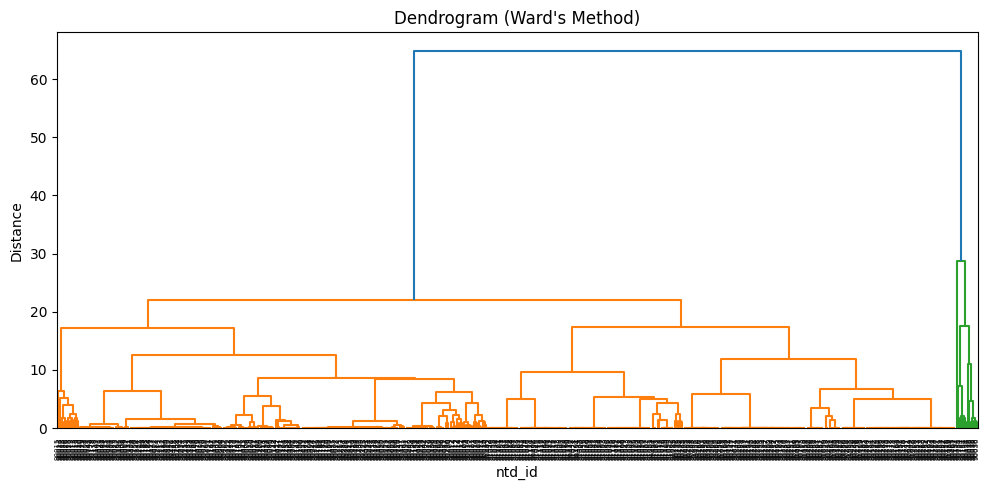

In [105]:
non_fixed_route_2023 = make_hierarchal_clustering(
    data = non_fixed_route_data,
    num_cols = numerical_cols,
    cat_cols = categorical_cols,
    cluster_num = 10
    
)

z_nonfixed_route = make_dendrogram_data(
    data = non_fixed_route_data,
    num_cols = numerical_cols,
    cat_cols = categorical_cols
)


for i in non_fixed_route_2023["cluster_name"].unique():
    print(f"""
    \n How many unique agencies are in Cluster {i}: {non_fixed_route_2023[non_fixed_route_2023['cluster_name']==i]["source_agency"].nunique()}
    Cluster {i} sample:""")
    display(non_fixed_route_2023[non_fixed_route_2023["cluster_name"]==i].head()),
    print(f"\nCluster {i} summary stats:")
    display(non_fixed_route_2023[non_fixed_route_2023["cluster_name"]==i].describe())

    
# fig_nonfixed_route = ff.create_dendrogram(z_nonfixed_route, labels = non_fixed_route_data["source_agency"].tolist())
# fig_nonfixed_route.update_layout(width=800, height=500)
# fig_nonfixed_route.show()

plt.figure(figsize=(10, 5))
dendrogram(z_nonfixed_route, labels=non_fixed_route_data["ntd_id"].tolist(), leaf_rotation=90)
plt.title("Dendrogram (Ward's Method)")
plt.xlabel("ntd_id")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

### 2023 data, fixed route modes , PT/DO service

In [71]:
fixed_route_data = ntd_2023_data[
    ntd_2023_data["mode"].isin(fixed_guideway)
].groupby(id_cols+categorical_cols).agg({
    i:"sum" for i in numerical_cols
}).reset_index()

fixed_route_data.head()

,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms
0,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",HR,DO,Full Reporter,30652076250,340509250,10654218625,97823119750,72750
1,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",MG,PT,Full Reporter,285853750,340509250,10654218625,97823119750,72750
2,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",YR,DO,Full Reporter,789821250,340509250,10654218625,97823119750,72750
3,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",HR,DO,Full Reporter,0,887382528,11150999040,232484337152,262144
4,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",LR,DO,Full Reporter,16989417472,887382528,11150999040,232484337152,262144



    
 How many unique agencies are in Cluster 8: 2
    Cluster 8 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
0,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",HR,DO,Full Reporter,30652076250,340509250,10654218625,97823119750,72750,8
3,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",HR,DO,Full Reporter,0,887382528,11150999040,232484337152,262144,8



    
 How many unique agencies are in Cluster 4: 2
    Cluster 4 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
1,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",MG,PT,Full Reporter,285853750,340509250,10654218625,97823119750,72750,4
11,90021,Los Angeles County Metropolitan Transportation...,0,"Los Angeles--Long Beach--Anaheim, CA",MG,DO,Full Reporter,0,0,0,0,0,4



    
 How many unique agencies are in Cluster 3: 2
    Cluster 3 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
2,90003,San Francisco Bay Area Rapid Transit District ...,Oakland,"San Francisco--Oakland, CA",YR,DO,Full Reporter,789821250,340509250,10654218625,97823119750,72750,3
16,90030,North County Transit District (NCTD),Oceanside,"San Diego, CA",YR,DO,Full Reporter,11052568746,383370894,5980799106,98931414123,137781,3
17,90030,North County Transit District (NCTD),Oceanside,"San Diego, CA",YR,PT,Full Reporter,0,383370894,5980799106,98931414123,137781,3



    
 How many unique agencies are in Cluster 7: 2
    Cluster 7 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
4,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",LR,DO,Full Reporter,16989417472,887382528,11150999040,232484337152,262144,7
6,90015,City and County of San Francisco (SFMTA) - Tra...,San Francisco,"San Francisco--Oakland, CA",LR,DO,Full Reporter,55898425310,1132664890,8302615811,334251644027,265482,7



    
 How many unique agencies are in Cluster 9: 1
    Cluster 9 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
5,90015,City and County of San Francisco (SFMTA) - Tra...,San Francisco,"San Francisco--Oakland, CA",CC,DO,Full Reporter,7026514495,1132664890,8302615811,334251644027,265482,9
7,90015,City and County of San Francisco (SFMTA) - Tra...,San Francisco,"San Francisco--Oakland, CA",SR,DO,Full Reporter,7529881744,1132664890,8302615811,334251644027,265482,9



    
 How many unique agencies are in Cluster 2: 2
    Cluster 2 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
8,90015,City and County of San Francisco (SFMTA) - Tra...,San Francisco,"San Francisco--Oakland, CA",TB,DO,Full Reporter,90504470490,1132664890,8302615811,334251644027,265482,2
12,90026,San Diego Metropolitan Transit System (MTS),San Diego,"San Diego, CA",LR,DO,Full Reporter,86549711360,882610687,11694910507,121153121614,265482,2



    
 How many unique agencies are in Cluster 6: 4
    Cluster 6 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
9,90019,Sacramento Regional Transit District,Sacramento,"Sacramento, CA",LR,DO,Full Reporter,14744348920,349659688,4813492558,81757163411,128282,6
10,90021,Los Angeles County Metropolitan Transportation...,0,"Los Angeles--Long Beach--Anaheim, CA",LR,DO,Full Reporter,0,0,0,0,0,6
15,90030,North County Transit District (NCTD),Oceanside,"San Diego, CA",LR,PT,Full Reporter,0,383370894,5980799106,98931414123,137781,6
20,90054,"San Diego Trolley, Inc. (MTS)",0,"San Diego, CA",LR,DO,Full Reporter,0,0,0,0,0,6



    
 How many unique agencies are in Cluster 0: 5
    Cluster 0 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
13,90030,North County Transit District (NCTD),Oceanside,"San Diego, CA",CR,DO,Full Reporter,5335451127,383370894,5980799106,98931414123,137781,0
14,90030,North County Transit District (NCTD),Oceanside,"San Diego, CA",CR,PT,Full Reporter,0,383370894,5980799106,98931414123,137781,0
21,90134,Peninsula Corridor Joint Powers Board (PCJPB),San Carlos,"San Francisco--Oakland, CA",CR,PT,Full Reporter,112193856,1713224,54405024,1383146680,680,0
22,90151,Southern California Regional Rail Authority (S...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",CR,DO,Full Reporter,0,2451112,88660488,2226664032,1560,0
23,90151,Southern California Regional Rail Authority (S...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",CR,PT,Full Reporter,59254464,2451112,88660488,2226664032,1560,0



    
 How many unique agencies are in Cluster 5: 1
    Cluster 5 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
18,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",CR,PT,Full Reporter,0,2764357893,37310649233,428923289696,1075448,5
19,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",SR,PT,Full Reporter,0,2764357893,37310649233,428923289696,1075448,5



    
 How many unique agencies are in Cluster 1: 1
    Cluster 1 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
24,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",HR,DO,Full Reporter,109997854720,4208721920,56047345152,1124671686144,1357312,1
25,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",LR,DO,Full Reporter,149864353792,4208721920,56047345152,1124671686144,1357312,1


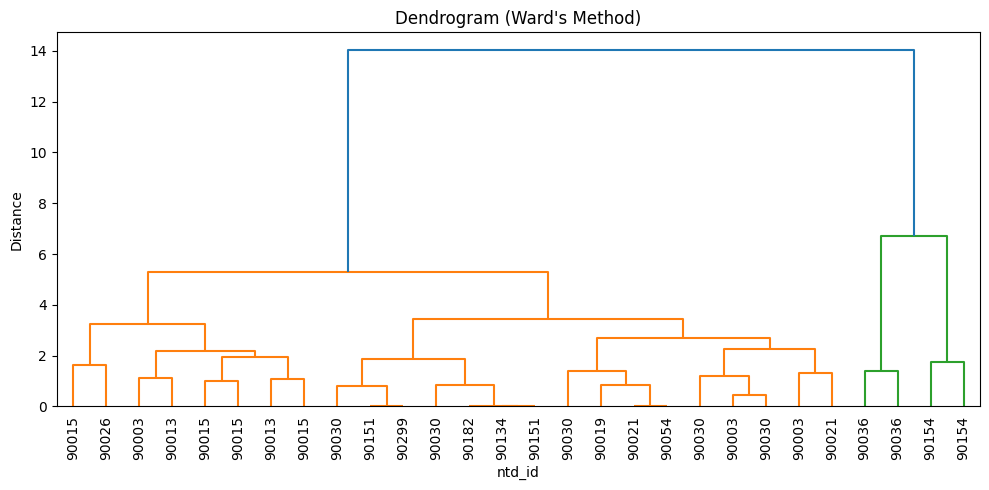

In [99]:
fixed_route_2023 = make_hierarchal_clustering(
    data = fixed_route_data,
    num_cols = numerical_cols,
    cat_cols = categorical_cols,
    cluster_num = 10
    
)

z_fixed_route = make_dendrogram_data(
    data = fixed_route_data,
    num_cols = numerical_cols,
    cat_cols = categorical_cols
)

for i in fixed_route_2023["cluster_name"].unique():
    print(f"""
    \n How many unique agencies are in Cluster {i}: {fixed_route_2023[fixed_route_2023['cluster_name']==i]["source_agency"].nunique()}
    Cluster {i} sample:""")
    display(fixed_route_2023[fixed_route_2023["cluster_name"]==i].head())

# fig_fixed_route = ff.create_dendrogram(z_fixed_route,)
# fig_fixed_route.update_layout(width=800, height=500)
# fig_fixed_route.show()

plt.figure(figsize=(10, 5))
dendrogram(z_fixed_route, labels=fixed_route_data["ntd_id"].tolist(), leaf_rotation=90)
plt.title("Dendrogram (Ward's Method)")
plt.xlabel("ntd_id")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

### 2023 data, other modes, PT/DO service

In [34]:
other_modes

['FB', 'OT', 'OR']


    
 How many unique agencies are in Cluster 2: 2
    Cluster 2 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
48,90150,City of Alameda Ferry Services,Inactive,0,"San Francisco--Oakland, CA",3515933,513.80,2023,FB,PT,Full Reporter,0,0,0,0,0,2
196,90028,City of Vallejo Transportation Program (Vallej...,Inactive,0,"Vallejo, CA",175132,39.64,2023,FB,PT,Full Reporter,0,0,0,0,0,2



Cluster 2 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,2.000000e+00,2.000000,2.0,2.0,2.0,2.0,2.0,2.0,2.0
mean,1.845532e+06,276.720000,2023.0,0.0,0.0,0.0,0.0,0.0,2.0
std,2.362303e+06,335.281751,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.751320e+05,39.640000,2023.0,0.0,0.0,0.0,0.0,0.0,2.0
25%,1.010332e+06,158.180000,2023.0,0.0,0.0,0.0,0.0,0.0,2.0
50%,1.845532e+06,276.720000,2023.0,0.0,0.0,0.0,0.0,0.0,2.0
75%,2.680733e+06,395.260000,2023.0,0.0,0.0,0.0,0.0,0.0,2.0
max,3.515933e+06,513.800000,2023.0,0.0,0.0,0.0,0.0,0.0,2.0



    
 How many unique agencies are in Cluster 0: 5
    Cluster 0 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
87,91040,City of Dinuba,Inactive,0,California Non-UZA,4357850,0.0,2023,OT,DO,Rural Reporter,0,0,0,0,0,0
167,91014,City of Rio Vista - Department of Public Works,Active,Rio Vista,California Non-UZA,4357850,0.0,2023,OT,DO,Rural Reporter,0,432,764208,9670104,124820352,0
211,91088,County of Glenn - Glenn County Planning and Co...,Active,Willows,California Non-UZA,4357850,0.0,2023,OT,DO,Rural Reporter,0,500,725000,16158500,121001250,0
265,91098,Lassen Transit Service Agency (LTSA),Active,Susanville,California Non-UZA,4357850,0.0,2023,OT,DO,Rural Reporter,0,320,542080,13096064,83503936,0
357,91009,San Benito County Local Transportation Authori...,Active,Hollister,California Non-UZA,4357850,0.0,2023,OT,DO,Rural Reporter,0,576,1540800,24304384,139715072,0



Cluster 0 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,5.0,5.0,5.0,5.0,5.000000,5.000000e+00,5.000000e+00,5.000000e+00,5.0
mean,4357850.0,0.0,2023.0,0.0,365.600000,7.144176e+05,1.264581e+07,9.380812e+07,0.0
std,0.0,0.0,0.0,0.0,224.990666,5.535322e+05,8.905552e+06,5.637999e+07,0.0
min,4357850.0,0.0,2023.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,4357850.0,0.0,2023.0,0.0,320.000000,5.420800e+05,9.670104e+06,8.350394e+07,0.0
50%,4357850.0,0.0,2023.0,0.0,432.000000,7.250000e+05,1.309606e+07,1.210012e+08,0.0
75%,4357850.0,0.0,2023.0,0.0,500.000000,7.642080e+05,1.615850e+07,1.248204e+08,0.0
max,4357850.0,0.0,2023.0,0.0,576.000000,1.540800e+06,2.430438e+07,1.397151e+08,0.0



    
 How many unique agencies are in Cluster 6: 1
    Cluster 6 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
191,90197,City of Tracy - Transit Division,Active,Tracy,"Tracy--Mountain House, CA",120912,27.05,2023,OR,PT,Reduced Reporter,0,832,2230528,23780096,356156864,6



Cluster 6 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,120912.0,27.05,2023.0,0.0,832.0,2230528.0,23780096.0,356156864.0,6.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,120912.0,27.05,2023.0,0.0,832.0,2230528.0,23780096.0,356156864.0,6.0
25%,120912.0,27.05,2023.0,0.0,832.0,2230528.0,23780096.0,356156864.0,6.0
50%,120912.0,27.05,2023.0,0.0,832.0,2230528.0,23780096.0,356156864.0,6.0
75%,120912.0,27.05,2023.0,0.0,832.0,2230528.0,23780096.0,356156864.0,6.0
max,120912.0,27.05,2023.0,0.0,832.0,2230528.0,23780096.0,356156864.0,6.0



    
 How many unique agencies are in Cluster 5: 1
    Cluster 5 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
243,90016,"Golden Gate Bridge, Highway and Transportation...",Active,San Francisco,"San Francisco--Oakland, CA",3515933,513.8,2023,FB,DO,Full Reporter,295854592,3968,9224960,153337920,7656014464,5



Cluster 5 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0
mean,3515933.0,513.8,2023.0,295854592.0,3968.0,9224960.0,153337920.0,7.656014e+09,5.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3515933.0,513.8,2023.0,295854592.0,3968.0,9224960.0,153337920.0,7.656014e+09,5.0
25%,3515933.0,513.8,2023.0,295854592.0,3968.0,9224960.0,153337920.0,7.656014e+09,5.0
50%,3515933.0,513.8,2023.0,295854592.0,3968.0,9224960.0,153337920.0,7.656014e+09,5.0
75%,3515933.0,513.8,2023.0,295854592.0,3968.0,9224960.0,153337920.0,7.656014e+09,5.0
max,3515933.0,513.8,2023.0,295854592.0,3968.0,9224960.0,153337920.0,7.656014e+09,5.0



    
 How many unique agencies are in Cluster 7: 1
    Cluster 7 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
273,90023,Long Beach Transit (LBT),Active,Long Beach,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,FB,PT,Full Reporter,0,20875,82099625,811577875,14032320000,7



Cluster 7 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.000000e+00,1.0
mean,12237376.0,1636.83,2023.0,0.0,20875.0,82099625.0,811577875.0,1.403232e+10,7.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,12237376.0,1636.83,2023.0,0.0,20875.0,82099625.0,811577875.0,1.403232e+10,7.0
25%,12237376.0,1636.83,2023.0,0.0,20875.0,82099625.0,811577875.0,1.403232e+10,7.0
50%,12237376.0,1636.83,2023.0,0.0,20875.0,82099625.0,811577875.0,1.403232e+10,7.0
75%,12237376.0,1636.83,2023.0,0.0,20875.0,82099625.0,811577875.0,1.403232e+10,7.0
max,12237376.0,1636.83,2023.0,0.0,20875.0,82099625.0,811577875.0,1.403232e+10,7.0



    
 How many unique agencies are in Cluster 9: 1
    Cluster 9 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
378,90225,San Francisco Bay Area Water Emergency Transpo...,Active,San Francisco,"San Francisco--Oakland, CA",3515933,513.8,2023,FB,PT,Full Reporter,32394336,88,198880,4121480,442400136,9



Cluster 9 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,3515933.0,513.8,2023.0,32394336.0,88.0,198880.0,4121480.0,442400136.0,9.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3515933.0,513.8,2023.0,32394336.0,88.0,198880.0,4121480.0,442400136.0,9.0
25%,3515933.0,513.8,2023.0,32394336.0,88.0,198880.0,4121480.0,442400136.0,9.0
50%,3515933.0,513.8,2023.0,32394336.0,88.0,198880.0,4121480.0,442400136.0,9.0
75%,3515933.0,513.8,2023.0,32394336.0,88.0,198880.0,4121480.0,442400136.0,9.0
max,3515933.0,513.8,2023.0,32394336.0,88.0,198880.0,4121480.0,442400136.0,9.0



    
 How many unique agencies are in Cluster 8: 1
    Cluster 8 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
430,99256,Susanville Indian Rancheria(SIR),Inactive,0,California Non-UZA,4357850,0.0,2023,OT,DO,Reduced Reporter,0,0,0,0,0,8



Cluster 8 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,4357850.0,0.0,2023.0,0.0,0.0,0.0,0.0,0.0,8.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,4357850.0,0.0,2023.0,0.0,0.0,0.0,0.0,0.0,8.0
25%,4357850.0,0.0,2023.0,0.0,0.0,0.0,0.0,0.0,8.0
50%,4357850.0,0.0,2023.0,0.0,0.0,0.0,0.0,0.0,8.0
75%,4357850.0,0.0,2023.0,0.0,0.0,0.0,0.0,0.0,8.0
max,4357850.0,0.0,2023.0,0.0,0.0,0.0,0.0,0.0,8.0



    
 How many unique agencies are in Cluster 3: 1
    Cluster 3 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
431,91089,Tehama County (TRAX),Active,Gerber,California Non-UZA,4357850,0.0,2023,OT,DO,Rural Reporter,0,1750,3433000,78797875,262690125,3



Cluster 3 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,3.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,3.0
25%,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,3.0
50%,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,3.0
75%,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,3.0
max,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,3.0



    
 How many unique agencies are in Cluster 4: 1
    Cluster 4 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
432,91089,Tehama County (TRAX),Active,Gerber,California Non-UZA,4357850,0.0,2023,OR,PT,Rural Reporter,0,1750,3433000,78797875,262690125,4



Cluster 4 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,4.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,4.0
25%,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,4.0
50%,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,4.0
75%,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,4.0
max,4357850.0,0.0,2023.0,0.0,1750.0,3433000.0,78797875.0,262690125.0,4.0



    
 How many unique agencies are in Cluster 1: 2
    Cluster 1 sample:


,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
468,99316,Chemehuevi Indian Tribe (CTA) - Reality and Pl...,Active,Havasu Lake,California Non-UZA,4357850,33.79,2023,FB,DO,Reduced Reporter,200000,2,6500,40000,1000200,1
666,99262,Yurok Tribe - Transportation Department,Active,Klamath,California Non-UZA,4357850,0.00,2023,FB,DO,Reduced Reporter,0,81,62100,814725,8607357,1



Cluster 1 summary stats:


,uza_population,uza_area_sq_miles,year,total_upt,total_voms,total_vrh,total_vrm,opexp_total,cluster_name
count,2.0,2.000000,2.0,2.000000,2.000000,2.000000,2.000000,2.000000e+00,2.0
mean,4357850.0,16.895000,2023.0,100000.000000,41.500000,34300.000000,427362.500000,4.803778e+06,1.0
std,0.0,23.893138,0.0,141421.356237,55.861436,39315.137034,547813.301055,5.379072e+06,0.0
min,4357850.0,0.000000,2023.0,0.000000,2.000000,6500.000000,40000.000000,1.000200e+06,1.0
25%,4357850.0,8.447500,2023.0,50000.000000,21.750000,20400.000000,233681.250000,2.901989e+06,1.0
50%,4357850.0,16.895000,2023.0,100000.000000,41.500000,34300.000000,427362.500000,4.803778e+06,1.0
75%,4357850.0,25.342500,2023.0,150000.000000,61.250000,48200.000000,621043.750000,6.705568e+06,1.0
max,4357850.0,33.790000,2023.0,200000.000000,81.000000,62100.000000,814725.000000,8.607357e+06,1.0


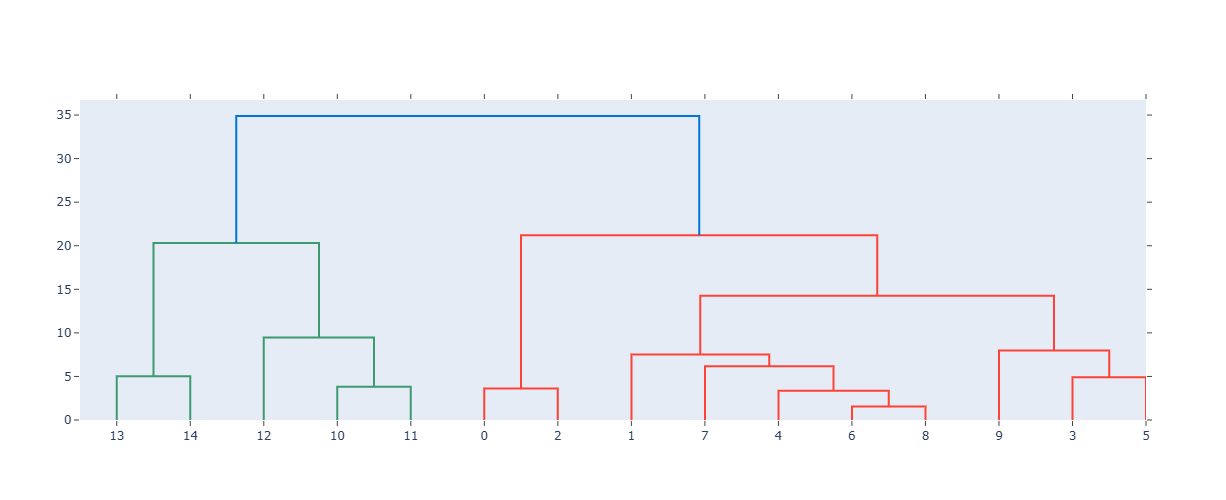

In [106]:


other_mode_2023 = make_hierarchal_clustering(
    data = ntd_2023_data[ntd_2023_data["mode"].isin(other_modes)],
    num_cols = numerical_cols,
    cat_cols = categorical_cols,
    cluster_num = 10
    
)

z_other_modes = make_dendrogram_data(
    data = ntd_2023_data[ntd_2023_data["mode"].isin(other_modes)],
    num_cols = numerical_cols,
    cat_cols = categorical_cols
)

for i in other_mode_2023["cluster_name"].unique():
    print(f"""
    \n How many unique agencies are in Cluster {i}: {other_mode_2023[other_mode_2023['cluster_name']==i]["source_agency"].nunique()}
    Cluster {i} sample:""")
    display(other_mode_2023[other_mode_2023["cluster_name"]==i].head()),
    print(f"\nCluster {i} summary stats:")
    display(other_mode_2023[other_mode_2023["cluster_name"]==i].describe())

    
fig_fixed_route = ff.create_dendrogram(z_other_modes)
fig_fixed_route.update_layout(width=800, height=500)
fig_fixed_route.show()

### non-fixed route, just DO


In [110]:
non_fixed_route_do = ntd_2023_data[
    (ntd_2023_data["mode"].isin(nonfixed_guideway))
    & (ntd_2023_data["service"]=="DO")
].groupby(id_cols+categorical_cols).agg({
    i:"sum" for i in numerical_cols
}).reset_index()

display(
    non_fixed_route_do.info(),
    non_fixed_route_do.head()
)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ntd_id            200 non-null    object
 1   source_agency     200 non-null    object
 2   city              200 non-null    object
 3   primary_uza_name  200 non-null    object
 4   mode              200 non-null    object
 5   service           200 non-null    object
 6   reporter_type     200 non-null    object
 7   total_upt         200 non-null    int64 
 8   total_vrh         200 non-null    int64 
 9   total_vrm         200 non-null    int64 
 10  opexp_total       200 non-null    int64 
 11  total_voms        200 non-null    int64 
dtypes: int64(5), object(7)
memory usage: 18.9+ KB


None

,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms
0,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",DR,DO,Full Reporter,13196115,7812126,105948432,986968422,2403
1,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",MB,DO,Full Reporter,253584918,7812126,105948432,986968422,2403
2,90006,Santa Cruz Metropolitan Transit District (SCMTD),Santa Cruz,"Santa Cruz, CA",CB,DO,Full Reporter,174624336,46385568,642627216,10490973336,20088
3,90006,Santa Cruz Metropolitan Transit District (SCMTD),Santa Cruz,"Santa Cruz, CA",DR,DO,Full Reporter,96194304,46385568,642627216,10490973336,20088
4,90006,Santa Cruz Metropolitan Transit District (SCMTD),Santa Cruz,"Santa Cruz, CA",MB,DO,Full Reporter,4070815056,46385568,642627216,10490973336,20088



    
 How many unique agencies are in Cluster 1: 49
    Cluster 1 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
0,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",DR,DO,Full Reporter,13196115,7812126,105948432,986968422,2403,1
3,90006,Santa Cruz Metropolitan Transit District (SCMTD),Santa Cruz,"Santa Cruz, CA",DR,DO,Full Reporter,96194304,46385568,642627216,10490973336,20088,1
7,90009,San Mateo County Transit District (SMCTD),San Carlos,"San Francisco--Oakland, CA",DR,DO,Full Reporter,0,140797224,1683438768,41590396728,71496,1
9,90010,City of Torrance (TTS) - Transit Department,Torrance,"Los Angeles--Long Beach--Anaheim, CA",DR,DO,Full Reporter,0,22361616,303016032,5522997960,15984,1
12,90012,San Joaquin Regional Transit District (RTD),Stockton,"Stockton, CA",DR,DO,Full Reporter,321540000,197664000,2612286000,42349184000,93000,1



Cluster 1 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,4.900000e+01,4.900000e+01,4.900000e+01,4.900000e+01,49.000000,49.0
mean,3.205577e+07,2.880182e+07,3.662369e+08,6.748467e+09,11245.877551,1.0
std,1.534663e+08,8.501556e+07,1.038962e+09,2.119181e+10,30353.916570,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.0
25%,0.000000e+00,3.489000e+03,2.718700e+04,5.813890e+05,3.000000,1.0
50%,7.472000e+03,2.306160e+05,2.174016e+06,2.818476e+07,120.000000,1.0
75%,7.269120e+05,7.812126e+06,1.059484e+08,1.025678e+09,2403.000000,1.0
max,1.030862e+09,4.422993e+08,4.827739e+09,1.149998e+11,133920.000000,1.0



    
 How many unique agencies are in Cluster 0: 54
    Cluster 0 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
1,90004,Golden Empire Transit District (GET),Bakersfield,"Bakersfield, CA",MB,DO,Full Reporter,253584918,7812126,105948432,986968422,2403,0
4,90006,Santa Cruz Metropolitan Transit District (SCMTD),Santa Cruz,"Santa Cruz, CA",MB,DO,Full Reporter,4070815056,46385568,642627216,10490973336,20088,0
5,90007,City of Modesto (MAX),0,"Modesto, CA",MB,DO,Full Reporter,0,0,0,0,0,0
6,90008,City of Santa Monica (BBB) - Department of Tra...,Santa Monica,"Los Angeles--Long Beach--Anaheim, CA",MB,DO,Full Reporter,4838286250,52118000,490049375,10097159000,17875,0
8,90009,San Mateo County Transit District (SMCTD),San Carlos,"San Francisco--Oakland, CA",MB,DO,Full Reporter,9016025760,140797224,1683438768,41590396728,71496,0



Cluster 0 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,5.600000e+01,5.600000e+01,5.600000e+01,5.600000e+01,56.000000,56.0
mean,2.467378e+09,4.040934e+07,5.393448e+08,9.135690e+09,15390.553571,0.0
std,6.588774e+09,9.549790e+07,1.277743e+09,2.349382e+10,33984.406349,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,0.000000e+00,6.572400e+04,7.853880e+05,8.558364e+06,68.250000,0.0
50%,6.523170e+06,2.253800e+06,2.645538e+07,3.274942e+08,988.000000,0.0
75%,8.971198e+08,2.140734e+07,2.817729e+08,5.502263e+09,8468.750000,0.0
max,3.891870e+10,4.422993e+08,5.980799e+09,1.149998e+11,137781.000000,0.0



    
 How many unique agencies are in Cluster 3: 21
    Cluster 3 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
2,90006,Santa Cruz Metropolitan Transit District (SCMTD),Santa Cruz,"Santa Cruz, CA",CB,DO,Full Reporter,174624336,46385568,642627216,10490973336,20088,3
11,90012,San Joaquin Regional Transit District (RTD),Stockton,"Stockton, CA",CB,DO,Full Reporter,363450000,197664000,2612286000,42349184000,93000,3
14,90012,San Joaquin Regional Transit District (RTD),Stockton,"Stockton, CA",RB,DO,Full Reporter,0,197664000,2612286000,42349184000,93000,3
15,90012,San Joaquin Regional Transit District (RTD),Stockton,"Stockton, CA",VP,DO,Full Reporter,0,197664000,2612286000,42349184000,93000,3
17,90014,Alameda-Contra Costa Transit District,Oakland,"San Francisco--Oakland, CA",CB,DO,Full Reporter,606088656,442299312,4827739104,114999842880,133920,3



Cluster 3 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,25.000000,25.0
mean,2.746930e+08,7.841794e+07,9.896583e+08,1.739625e+10,30308.480000,3.0
std,1.062782e+09,1.310561e+08,1.519085e+09,3.268639e+10,44403.424952,0.0
min,0.000000e+00,1.389200e+05,3.792968e+06,1.324137e+07,72.000000,3.0
25%,0.000000e+00,8.604090e+05,1.707691e+07,1.248204e+08,743.000000,3.0
50%,0.000000e+00,4.746250e+06,1.059334e+08,4.227581e+08,3648.000000,3.0
75%,3.569288e+06,5.990221e+07,9.834629e+08,1.049097e+10,35640.000000,3.0
max,5.321544e+09,4.422993e+08,4.827739e+09,1.149998e+11,133920.000000,3.0



    
 How many unique agencies are in Cluster 2: 3
    Cluster 2 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
16,90013,Santa Clara Valley Transportation Authority (VTA),San Jose,"San Jose, CA",MB,DO,Full Reporter,78917459968,887382528,11150999040,232484337152,262144,2
21,90015,City and County of San Francisco (SFMTA) - Tra...,San Francisco,"San Francisco--Oakland, CA",MB,DO,Full Reporter,172516414301,1132664890,8302615811,334251644027,265482,2
33,90026,San Diego Metropolitan Transit System (MTS),San Diego,"San Diego, CA",MB,DO,Full Reporter,39662195832,882610687,11694910507,121153121614,265482,2



Cluster 2 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000,3.0
mean,9.703202e+10,9.675527e+08,1.038284e+10,2.292964e+11,264369.333333,2.0
std,6.825441e+10,1.430113e+08,1.821940e+09,1.065850e+11,1927.195199,0.0
min,3.966220e+10,8.826107e+08,8.302616e+09,1.211531e+11,262144.000000,2.0
25%,5.928983e+10,8.849966e+08,9.726807e+09,1.768187e+11,263813.000000,2.0
50%,7.891746e+10,8.873825e+08,1.115100e+10,2.324843e+11,265482.000000,2.0
75%,1.257169e+11,1.010024e+09,1.142295e+10,2.833680e+11,265482.000000,2.0
max,1.725164e+11,1.132665e+09,1.169491e+10,3.342516e+11,265482.000000,2.0



    
 How many unique agencies are in Cluster 7: 1
    Cluster 7 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
41,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",CB,DO,Full Reporter,0,2764357893,37310649233,428923289696,1075448,7
43,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",VP,DO,Full Reporter,0,2764357893,37310649233,428923289696,1075448,7



Cluster 7 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,2.0,2.000000e+00,2.000000e+00,2.000000e+00,2.0,2.0
mean,0.0,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,7.0
std,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
min,0.0,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,7.0
25%,0.0,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,7.0
50%,0.0,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,7.0
75%,0.0,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,7.0
max,0.0,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,7.0



    
 How many unique agencies are in Cluster 8: 1
    Cluster 8 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
42,90036,Orange County Transportation Authority (OCTA),Orange,"Los Angeles--Long Beach--Anaheim, CA",MB,DO,Full Reporter,331437877573,2764357893,37310649233,428923289696,1075448,8



Cluster 8 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
mean,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,8.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,8.0
25%,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,8.0
50%,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,8.0
75%,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,8.0
max,3.314379e+11,2.764358e+09,3.731065e+10,4.289233e+11,1075448.0,8.0



    
 How many unique agencies are in Cluster 4: 1
    Cluster 4 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
68,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",DR,DO,Full Reporter,2851143680,4208721920,56047345152,1124671686144,1357312,4
70,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",RB,DO,Full Reporter,17907421184,4208721920,56047345152,1124671686144,1357312,4



Cluster 4 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.0,2.0
mean,1.037928e+10,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,4.0
std,1.064640e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
min,2.851144e+09,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,4.0
25%,6.615213e+09,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,4.0
50%,1.037928e+10,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,4.0
75%,1.414335e+10,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,4.0
max,1.790742e+10,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,4.0



    
 How many unique agencies are in Cluster 5: 1
    Cluster 5 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
69,90154,Los Angeles County Metropolitan Transportation...,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA",MB,DO,Full Reporter,805546905600,4208721920,56047345152,1124671686144,1357312,5



Cluster 5 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0
mean,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0
25%,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0
50%,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0
75%,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0
max,8.055469e+11,4.208722e+09,5.604735e+10,1.124672e+12,1357312.0,5.0



    
 How many unique agencies are in Cluster 6: 32
    Cluster 6 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
115,91000,Amador Transit (AT),Jackson,California Non-UZA,DR,DO,Rural Reporter,815103,347679,6944616,40079880,486,6
117,91002,City of Corcoran (CAT ) - Transit,Corcoran,California Non-UZA,DR,DO,Rural Reporter,25199,3691,31978,881668,4,6
120,91006,City of Ridgecrest (RTS) - Transit Division / ...,Ridgecrest,California Non-UZA,DR,DO,Rural Reporter,142496,35064,506256,9615040,40,6
122,91007,Fresno County Rural Transit Agency (FCRTA),Fresno,California Non-UZA,DR,DO,Rural Reporter,0,3803776,43219968,455201408,4160,6
124,91008,Modoc Transportation Agency (MTA),Alturas,California Non-UZA,DR,DO,Rural Reporter,0,438208,7062080,31777088,192,6



Cluster 6 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,32.000000,32.0
mean,6.184612e+05,6.117000e+05,1.015344e+07,6.759276e+07,440.500000,6.0
std,2.390563e+06,1.203429e+06,2.167742e+07,1.250049e+08,974.443994,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,6.0
25%,0.000000e+00,4.012750e+03,4.887200e+04,8.247830e+05,7.000000,6.0
50%,1.445050e+04,5.065900e+04,7.041750e+05,7.011720e+06,44.000000,6.0
75%,3.437760e+05,6.431540e+05,9.577446e+06,6.756040e+07,371.250000,6.0
max,1.358234e+07,4.746250e+06,1.059334e+08,4.552014e+08,4160.000000,6.0



    
 How many unique agencies are in Cluster 9: 29
    Cluster 9 sample:


,ntd_id,source_agency,city,primary_uza_name,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
116,91000,Amador Transit (AT),Jackson,California Non-UZA,MB,DO,Rural Reporter,1659204,347679,6944616,40079880,486,9
121,91006,City of Ridgecrest (RTS) - Transit Division / ...,Ridgecrest,California Non-UZA,MB,DO,Rural Reporter,22720,35064,506256,9615040,40,9
123,91007,Fresno County Rural Transit Agency (FCRTA),Fresno,California Non-UZA,MB,DO,Rural Reporter,0,3803776,43219968,455201408,4160,9
125,91008,Modoc Transportation Agency (MTA),Alturas,California Non-UZA,MB,DO,Rural Reporter,0,438208,7062080,31777088,192,9
128,91012,Mountain Area Regional Transit Authority (MARTA),Big Bear Lake,California Non-UZA,MB,DO,Rural Reporter,66137310,1395063,20007108,148435335,810,9



Cluster 9 summary stats:


,total_upt,total_vrh,total_vrm,opexp_total,total_voms,cluster_name
count,2.900000e+01,2.900000e+01,2.900000e+01,2.900000e+01,29.000000,29.0
mean,1.052596e+07,7.145916e+05,1.195395e+07,8.006901e+07,505.517241,9.0
std,4.147871e+07,1.232197e+06,2.224402e+07,1.270873e+08,1006.171727,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,9.0
25%,0.000000e+00,3.648000e+04,5.062560e+05,5.409984e+06,24.000000,9.0
50%,0.000000e+00,2.199200e+05,5.315841e+06,3.177709e+07,136.000000,9.0
75%,8.820000e+05,7.250000e+05,9.670104e+06,1.194066e+08,432.000000,9.0
max,2.164316e+08,4.746250e+06,1.059334e+08,4.552014e+08,4160.000000,9.0


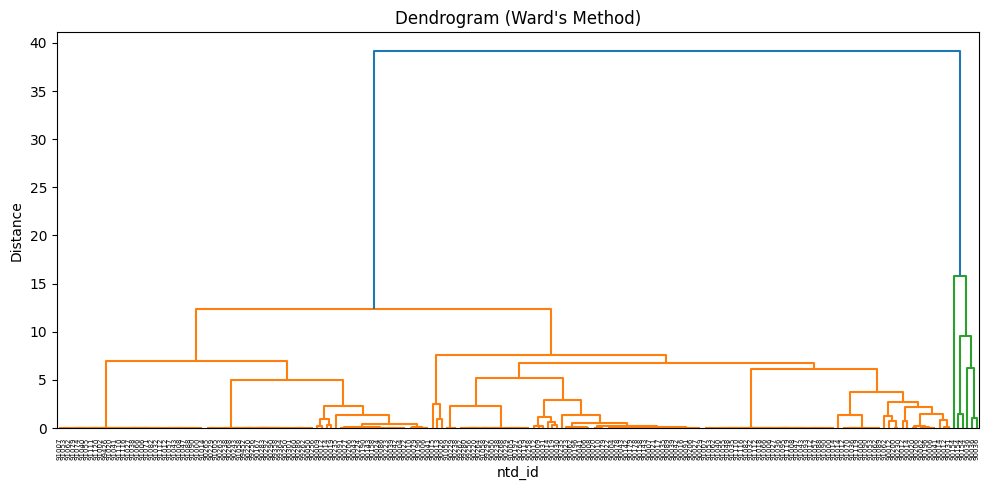

In [109]:
non_fixed_route_do_2023 = make_hierarchal_clustering(
    data = non_fixed_route_do,
    num_cols = numerical_cols,
    cat_cols = categorical_cols,
    cluster_num = 10
    
)

z_nonfixed_route_do = make_dendrogram_data(
    data = non_fixed_route_do,
    num_cols = numerical_cols,
    cat_cols = categorical_cols
)


for i in non_fixed_route_do_2023["cluster_name"].unique():
    print(f"""
    \n How many unique agencies are in Cluster {i}: {non_fixed_route_do_2023[non_fixed_route_do_2023['cluster_name']==i]["source_agency"].nunique()}
    Cluster {i} sample:""")
    display(non_fixed_route_do_2023[non_fixed_route_do_2023["cluster_name"]==i].head()),
    print(f"\nCluster {i} summary stats:")
    display(non_fixed_route_do_2023[non_fixed_route_do_2023["cluster_name"]==i].describe())

    
# fig_nonfixed_route = ff.create_dendrogram(z_nonfixed_route, labels = non_fixed_route_data["source_agency"].tolist())
# fig_nonfixed_route.update_layout(width=800, height=500)
# fig_nonfixed_route.show()

plt.figure(figsize=(10, 5))
dendrogram(z_nonfixed_route_do, labels=non_fixed_route_do["ntd_id"].tolist(), leaf_rotation=90)
plt.title("Dendrogram (Ward's Method)")
plt.xlabel("ntd_id")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()